<a href="https://colab.research.google.com/github/kenpurin/Retrosynthesis_TF/blob/main/Transformer_Retrosynthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LANGUAGE TRANSLATION WITH TRANSFORMER

In [6]:
!nvidia-smi

Sun Jun  6 07:57:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#load data and insatall

In [8]:
!git clone https://github.com/kenpurin/Retrosynthesis_TF.git

Cloning into 'Retrosynthesis_TF'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 133 (delta 62), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (133/133), 3.78 MiB | 3.40 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [9]:
!pip3 install rich
!pip3 show torch

     |████████████████████████████████| 204kB 7.6MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
Name: torch
Version: 1.8.1+cu101
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions, numpy
Required-by: torchvision, torchtext, fastai


# Data Processing

In [10]:
import math
import torchtext
import torch
import torch.nn as nn
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
from torch import Tensor
import io
import time
from rich import print
import matplotlib.pyplot as plt


In [11]:
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torch.cuda.is_available())

if device.type == 'cuda':
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
!nvcc --version

1.8.1+cu101

True

Tesla P100-PCIE-16GB

Memory Usage:

Allocated: 0.0 GB

Cached:    0.0 GB

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [12]:
#load data USPTO-50K
train_src_filepaths='Retrosynthesis_TF/USPTO-50K/src/src-train.txt'
train_tgt_filepaths='Retrosynthesis_TF/USPTO-50K/tgt/tgt-train.txt'
val_src_filepaths='Retrosynthesis_TF/USPTO-50K/src/src-val.txt'
val_tgt_filepaths='Retrosynthesis_TF/USPTO-50K/tgt/tgt-val.txt'
test_src_filepaths='Retrosynthesis_TF/USPTO-50K/src/src-test.txt'
test_tgt_filepaths='Retrosynthesis_TF/USPTO-50K/tgt/tgt-test.txt'

In [13]:
#build_vocab
src_filepath='Retrosynthesis_TF/USPTO-50K/src/src.txt'
tgt_filepath='Retrosynthesis_TF/USPTO-50K/tgt/tgt.txt'

In [14]:
#https://pytorch.org/text/stable/data_utils.html use toktok or spacy
tokenizer = get_tokenizer('toktok')

In [15]:
def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_))
  return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
src_vocab = build_vocab(src_filepath,tokenizer)
tgt_vocab = build_vocab(tgt_filepath,tokenizer)

In [16]:
def data_process(filepaths1,filepaths2):
  raw_src_iter = iter(io.open(filepaths1, encoding="utf8"))
  raw_tgt_iter = iter(io.open(filepaths2, encoding="utf8"))
  data = []
  for (raw_src, raw_tgt) in zip(raw_src_iter, raw_tgt_iter):
    src_tensor_ = torch.tensor([src_vocab[token] for token in tokenizer(raw_src.rstrip("\n"))],
                            dtype=torch.long)
    tgt_tensor_ = torch.tensor([tgt_vocab[token] for token in tokenizer(raw_tgt.rstrip("\n"))],
                            dtype=torch.long)
    data.append((src_tensor_, tgt_tensor_))
  return data

In [17]:
train_data = data_process(train_src_filepaths,train_tgt_filepaths)
val_data = data_process(val_src_filepaths,val_tgt_filepaths)
test_data = data_process(test_src_filepaths,test_tgt_filepaths)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#default BATCH_SIZE =128
BATCH_SIZE = 32
PAD_IDX = src_vocab['<pad>']
BOS_IDX = src_vocab['<bos>']
EOS_IDX = src_vocab['<eos>']

# DataLoader

In [19]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
  src_batch, tgt_batch = [], []
  for (src_item, tgt_item) in data_batch:
    src_batch.append(torch.cat([torch.tensor([BOS_IDX]), src_item, torch.tensor([EOS_IDX])], dim=0))
    tgt_batch.append(torch.cat([torch.tensor([BOS_IDX]), tgt_item, torch.tensor([EOS_IDX])], dim=0))
  src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
  tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
  return src_batch, tgt_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

#Transformer

In [20]:
#https://pytorch.org/docs/master/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention
from torch.nn import (TransformerEncoder, TransformerDecoder,
                      TransformerEncoderLayer, TransformerDecoderLayer)


class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int,
                 emb_size: int, src_vocab_size: int, tgt_vocab_size: int,
                 dim_feedforward:int = 512, dropout:float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        #TransformerEncoderLayer is made up of self-attn and feedforward network.
        encoder_layer = TransformerEncoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        #TransformerEncoder is a stack of N encoder layers
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        #	TransformerDecoderLayer is made up of self-attn, multi-head-attn and feedforward network.
        decoder_layer = TransformerDecoderLayer(d_model=emb_size, nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        #TransformerDecoder is a stack of N decoder layers
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor,
                tgt_mask: Tensor, src_padding_mask: Tensor,
                tgt_padding_mask: Tensor, memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        memory = self.transformer_encoder(src_emb, src_mask, src_padding_mask)
        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, None,
                                        tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer_encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer_decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [21]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding +
                            self.pos_embedding[:token_embedding.size(0),:])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [22]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
  src_seq_len = src.shape[0]
  tgt_seq_len = tgt.shape[0]

  tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
  src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

  src_padding_mask = (src == PAD_IDX).transpose(0, 1)
  tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
  return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [23]:
# Training hyperparameters
#default BATCH_SIZE = 128 NUM_ENCODER_LAYERS = 3 NUM_DECODER_LAYERS = 3

SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(tgt_vocab)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 32
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
NUM_EPOCHS = 100

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS,
                                 EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                 FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
#model 
transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
#default optimizer  lr=0.0001 ,betas=(0.9, 0.98) ,eps=1e-9
optimizer = torch.optim.Adam(
    transformer.parameters(), lr=2, betas=(0.9, 0.998), eps=1e-9
)

In [24]:
#show model
print(transformer)

Seq2SeqTransformer(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (2): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (3): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (dropout3): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias

#Save checkpoint

In [25]:
load_model = True
save_model = True

In [26]:
def save_checkpoint(state, filename):
    #filename="my_checkpoint_"+str(epoch)+".pth"
    print("=> Saving checkpoint")
    torch.save(state, filename)

#Load checkpoint

In [ ]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
if load_model:
    load_checkpoint(torch.load("/content/gdrive/MyDrive/code retrosynthesis/checkpoint/my_checkpoint_200.pth"), transformer, optimizer)



=> Loading checkpoint

# Train and Evaluate function

In [27]:
def train_epoch(model, train_iter, optimizer):
  model.train()
  losses = 0
  for idx, (src, tgt) in enumerate(train_iter):
      src = src.to(device)
      tgt = tgt.to(device)

      tgt_input = tgt[:-1, :]

      src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

      logits = model(src, tgt_input, src_mask, tgt_mask,
                                src_padding_mask, tgt_padding_mask, src_padding_mask)

      optimizer.zero_grad()

      tgt_out = tgt[1:,:]
      loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
      loss.backward()

      optimizer.step()
      losses += loss.item()
  return losses / len(train_iter)


def evaluate(model, val_iter):
  model.eval()
  losses = 0
  for idx, (src, tgt) in (enumerate(valid_iter)):
    src = src.to(device)
    tgt = tgt.to(device)

    tgt_input = tgt[:-1, :]

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

    logits = model(src, tgt_input, src_mask, tgt_mask,
                              src_padding_mask, tgt_padding_mask, src_padding_mask)
    tgt_out = tgt[1:,:]
    loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
    losses += loss.item()
  return losses / len(val_iter)

#Train model

In [ ]:
train_loss_ex = []
val_loss_ex = []
epoch_ex=[]
for epoch in range(1, NUM_EPOCHS+1):
  start_time = time.time()
  train_loss = train_epoch(transformer, train_iter, optimizer)
  end_time = time.time()
  val_loss = evaluate(transformer, valid_iter)
  #Save the general checkpoint
  if epoch%100==0:
    filename="my_checkpoint_"+str(epoch)+".pth"
    print("true")
    checkpoint = {"state_dict": transformer.state_dict(),"optimizer": optimizer.state_dict(),}
    save_checkpoint(checkpoint,filename)

  print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "
          f"Epoch time = {(end_time - start_time):.3f}s"))
  #plot
  train_loss_ex.append(train_loss)
  epoch_ex.append(epoch)
  val_loss_ex.append(val_loss)
  
print("Done!")

Epoch: 1, Train loss: 0.023, Val loss: 0.134, Epoch time = 94.601s

Done!

#Plot graph

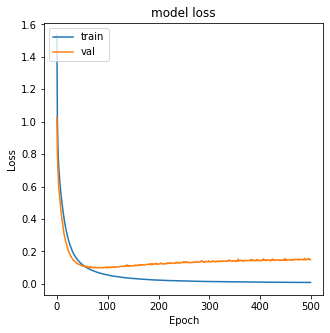

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
import numpy as np
#https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
plt.figure(figsize=(5,5))
plt.plot(train_loss_ex)
plt.plot(val_loss_ex)
#plt.yticks(np.arange(0.2, 1.5, step=0.1))
#plt.xticks(np.arange(1, 15, step=1))
plt.title("model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#total_data_loss = pd.Series(epoch_ex,train_loss_ex,val_loss_ex)
total_train_loss = pd.Series(train_loss_ex)
total_val_loss = pd.Series(val_loss_ex)
total_train_loss=pd.DataFrame(total_train_loss, columns=["train loss"])
total_val_loss =pd.DataFrame(total_val_loss, columns=["val loss"])
total_data_loss=pd.concat([total_train_loss,total_val_loss], axis=1)
total_train_loss
total_data_loss.to_csv(r'total_loss.csv',  index=None)

# Save model

In [ ]:
#https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [ ]:
save_name="model_tranformer_epochs_"+str(NUM_EPOCHS)+".pth"
torch.save(transformer,save_name)

In [ ]:
from google.colab import files
files.download(save_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

save file .pt

In [ ]:
save_name_pt="model_tranformer_epochs_"+str(NUM_EPOCHS)+".pt"
torch.save(transformer,save_name_pt)

In [ ]:
files.download("/content/my_checkpoint_300.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load model

In [28]:
model = torch.load('/content/gdrive/MyDrive/code retrosynthesis/model/model_tranformer_epochs_500.pth')
print(True)

#Translation

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df_src=pd.read_csv(src_filepath,names=["input"])
df_tgt=pd.read_csv(tgt_filepath,names=["target"])
df = pd.concat([df_src,df_tgt], axis=1)
df

,input,target
0,<RX_1> O = C 1 C C [ C @ H ] ( C N 2 C C N ( C...,C S ( = O ) ( = O ) O C [ C @ H ] 1 C C C ( = ...
1,<RX_6> N c 1 n c 2 [ n H ] c ( C C C c 3 c s c...,C O C ( = O ) c 1 c c ( C C C c 2 c c 3 c ( = ...
2,<RX_9> C C 1 ( C ) O B ( c 2 c c c c ( N c 3 n...,C C 1 ( C ) O B ( B 2 O C ( C ) ( C ) C ( C ) ...
3,<RX_6> C C ( C ) ( C ) O C ( = O ) N C C ( = O...,C C ( C ) ( C ) O C ( = O ) N C C ( = O ) C C ...
4,<RX_1> F c 1 c c 2 c ( N C 3 C C C C C C 3 ) n...,F c 1 c c 2 c ( C l ) n c n c 2 c n 1 . N C 1 ...
...,...,...
50032,<RX_1> C C ( C ) ( C ) O C ( = O ) N 1 C C c 2...,C C ( C ) ( C ) O C ( = O ) N 1 C C c 2 c c c ...
50033,<RX_2> C C ( = O ) O C C N C ( = O ) O C ( C )...,C C ( = O ) C l . C C ( C ) ( C ) O C ( = O ) ...
50034,<RX_3> C c 1 c c c ( - c 2 c c n c c 2 ) c c 1...,C c 1 c c c ( B r ) c c 1 C = O . O B ( O ) c ...
50035,<RX_1> C C ( C ) ( C ) O C 1 C [ C @ @ H ] 2 C...,C C ( C ) ( C ) O . O = C C 1 = C [ C @ H ] 2 ...


In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        
        if next_word == EOS_IDX:
          break
    return ys


def translate(model, src, src_vocab, tgt_vocab, src_tokenizer):
  model.eval()
  tokens = [BOS_IDX] + [src_vocab.stoi[tok] for tok in src_tokenizer(src)]+ [EOS_IDX]
  num_tokens = len(tokens)
  src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
  tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
 
  print("Product:"+ " "+df.input[i])
  print("Reaction Real:"+" "+df.target[i])
  return print("prediction:"+" ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", ""))
  #return " ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", "")

In [ ]:
i=50034
translate(transformer, df.input[i], src_vocab, tgt_vocab, tokenizer)

Product: <RX_3> C c 1 c c c ( - c 2 c c n c c 2 ) c c 1 C = O

Reaction Real: C c 1 c c c ( B r ) c c 1 C = O . O B ( O ) c 1 c c n c c 1

prediction: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 
<unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 
<unk> <unk>

In [ ]:
for i in range(50000,50010):
  translate(transformer, df.input[i], src_vocab, tgt_vocab, tokenizer)
  print("    ")

#beam search 

In [29]:
import pandas as pd
import numpy as np
df_src=pd.read_csv(src_filepath,names=["input"])
df_tgt=pd.read_csv(tgt_filepath,names=["target"])
df = pd.concat([df_src,df_tgt], axis=1)

In [30]:
df_test=pd.read_csv("/content/Retrosynthesis_TF/USPTO-50K/src/src-test.txt",names=["input"])
df_test

,input
0,<RX_1> C O C ( = O ) C C C ( = O ) c 1 c c c (...
1,<RX_4> C O C ( = O ) c 1 c c c c ( - c 2 n c 3...
2,<RX_2> C O N ( C ) C ( = O ) C 1 C C C ( N C (...
3,<RX_1> O = [ N + ] ( [ O - ] ) c 1 c c c ( C l...
4,<RX_9> N C C 1 = C C [ C @ @ H ] ( c 2 c c c (...
...,...
4999,<RX_1> C c 1 c c ( [ N + ] ( = O ) [ O - ] ) c...
5000,<RX_6> C O C ( = O ) c 1 [ n H ] c 2 c c ( C l...
5001,<RX_7> C O c 1 c c ( C ( F ) ( F ) F ) c c ( S...
5002,<RX_10> C c 1 n n ( C C ( C ) C O ) c ( - c 2 ...


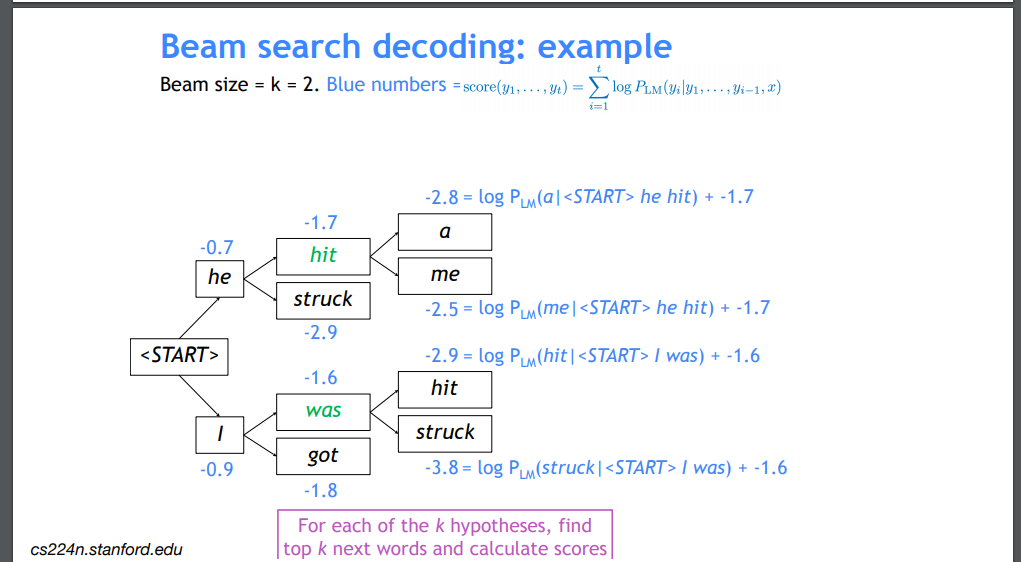

ref https://attapol.github.io/compling/slides/machine-translation-2020.pdf

In [32]:
#https://towardsdatascience.com/boosting-your-sequence-generation-performance-with-beam-search-language-model-decoding-74ee64de435a

import numpy as np
import math

def beam_search_decoder(predictions, top_k = 3):
    #start with an empty sequence with zero score
    output_sequences = [([], 0)]
    
    #looping through all the predictions
    for token_probs in predictions:
        new_sequences = []
        
        #append new tokens to old sequences and re-score
        for old_seq, old_score in output_sequences:
            for char_index in range(len(token_probs)):
                
                new_seq = old_seq + [char_index]
                print(new_seq)
                #considering log-likelihood for scoring
                new_score = old_score + math.log(token_probs[char_index])
                print(old_score )
                #print(new_seq, new_score)
                #print(token_probs[char_index],math.log(token_probs[char_index]))
                new_sequences.append((new_seq, new_score))
                #print(new_sequences)
                
        #sort all new sequences in the de-creasing order of their score
        output_sequences = sorted(new_sequences, key = lambda val: val[1], reverse = True)
        
        #select top-k based on score 
        # *Note- best sequence is with the highest score
        output_sequences = output_sequences[:top_k]
        
    return output_sequences
    

model_prediction = [[0.1, 0.7, 0.1, 0.1],
                    [0.7, 0.1, 0.1, 0.1],
                    [0.1, 0.1, 0.6, 0.2],
                    [0.1, 0.1, 0.1, 0.7],
                    [0.4, 0.3, 0.2, 0.1]]
                    
beam_search_decoder(model_prediction, top_k = 5)



[0]

0

[1]

0

[2]

0

[3]

0

[1, 0]

-0.35667494393873245

[1, 1]

-0.35667494393873245

[1, 2]

-0.35667494393873245

[1, 3]

-0.35667494393873245

[0, 0]

-2.3025850929940455

[0, 1]

-2.3025850929940455

[0, 2]

-2.3025850929940455

[0, 3]

-2.3025850929940455

[2, 0]

-2.3025850929940455

[2, 1]

-2.3025850929940455

[2, 2]

-2.3025850929940455

[2, 3]

-2.3025850929940455

[3, 0]

-2.3025850929940455

[3, 1]

-2.3025850929940455

[3, 2]

-2.3025850929940455

[3, 3]

-2.3025850929940455

[1, 0, 0]

-0.7133498878774649

[1, 0, 1]

-0.7133498878774649

[1, 0, 2]

-0.7133498878774649

[1, 0, 3]

-0.7133498878774649

[1, 1, 0]

-2.659260036932778

[1, 1, 1]

-2.659260036932778

[1, 1, 2]

-2.659260036932778

[1, 1, 3]

-2.659260036932778

[1, 2, 0]

-2.659260036932778

[1, 2, 1]

-2.659260036932778

[1, 2, 2]

-2.659260036932778

[1, 2, 3]

-2.659260036932778

[1, 3, 0]

-2.659260036932778

[1, 3, 1]

-2.659260036932778

[1, 3, 2]

-2.659260036932778

[1, 3, 3]

-2.659260036932778

[0, 0, 0]

-2.659260036932778

[0, 0, 1]

-2.659260036932778

[0, 0, 2]

-2.659260036932778

[0, 0, 3]

-2.659260036932778

[1, 0, 2, 0]

-1.2241755116434556

[1, 0, 2, 1]

-1.2241755116434556

[1, 0, 2, 2]

-1.2241755116434556

[1, 0, 2, 3]

-1.2241755116434556

[1, 0, 3, 0]

-2.3227878003115654

[1, 0, 3, 1]

-2.3227878003115654

[1, 0, 3, 2]

-2.3227878003115654

[1, 0, 3, 3]

-2.3227878003115654

[1, 0, 0, 0]

-3.0159349808715104

[1, 0, 0, 1]

-3.0159349808715104

[1, 0, 0, 2]

-3.0159349808715104

[1, 0, 0, 3]

-3.0159349808715104

[1, 0, 1, 0]

-3.0159349808715104

[1, 0, 1, 1]

-3.0159349808715104

[1, 0, 1, 2]

-3.0159349808715104

[1, 0, 1, 3]

-3.0159349808715104

[1, 1, 2, 0]

-3.170085660698769

[1, 1, 2, 1]

-3.170085660698769

[1, 1, 2, 2]

-3.170085660698769

[1, 1, 2, 3]

-3.170085660698769

[1, 0, 2, 3, 0]

-1.580850455582188

[1, 0, 2, 3, 1]

-1.580850455582188

[1, 0, 2, 3, 2]

-1.580850455582188

[1, 0, 2, 3, 3]

-1.580850455582188

[1, 0, 3, 3, 0]

-2.679462744250298

[1, 0, 3, 3, 1]

-2.679462744250298

[1, 0, 3, 3, 2]

-2.679462744250298

[1, 0, 3, 3, 3]

-2.679462744250298

[1, 0, 0, 3, 0]

-3.372609924810243

[1, 0, 0, 3, 1]

-3.372609924810243

[1, 0, 0, 3, 2]

-3.372609924810243

[1, 0, 0, 3, 3]

-3.372609924810243

[1, 0, 1, 3, 0]

-3.372609924810243

[1, 0, 1, 3, 1]

-3.372609924810243

[1, 0, 1, 3, 2]

-3.372609924810243

[1, 0, 1, 3, 3]

-3.372609924810243

[1, 0, 2, 0, 0]

-3.5267606046375013

[1, 0, 2, 0, 1]

-3.5267606046375013

[1, 0, 2, 0, 2]

-3.5267606046375013

[1, 0, 2, 0, 3]

-3.5267606046375013

[([1, 0, 2, 3, 0], -2.497141187456343),
 ([1, 0, 2, 3, 1], -2.784823259908124),
 ([1, 0, 2, 3, 2], -3.1902883680162883),
 ([1, 0, 3, 3, 0], -3.595753476124453),
 ([1, 0, 2, 3, 3], -3.8834355485762337)]

In [34]:
#https://github.com/bigchem/synthesis/blob/master/transformer.py

import math
#a=-math.log(0.7)
#print(a)


In [79]:
def beam_decode(model, src, src_mask, max_len, start_symbol,k):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    output_sequences = [([], 0)]
    old_prob=[]
    old_score=[]
    old_index=[]
    new_sequences=[]
    a=[]
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        #print(prob)



        #note topK
        prb,next_topk=torch.topk(prob,k,dim=1)
        
        #print(torch.topk(prob,k,dim=1))
        #keep default prb
        if i==0:
          #print(torch.topk(prob,k,dim=1))

          for n in range(k):
            
            old_prob.append(prb[0][n].item())
            old_index.append(next_topk[0][n].item())
            new_sequences.append((prb[0][n].item(),next_topk[0][n].item()))
          print(old_prob)
          a=torch.tensor([old_prob]).to(device)
          #a=a.transpose(0, 1)
          #a=a[:,-1]
          print(a)
          print(torch.topk(a,k,dim=1))
 



          #print(old_index) 
         #print(new_sequences)
          #print(new_sequences[1])
    
        if i>0:
          None 


        #print(prb[0][0])
        #print(next_topk[0][0])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()
        #key pull numer out tensor
        next_topk_k=next_topk[0][0].item()

        print(next_topk[0][0])
        ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_topk_k)], dim=0)
        
        if next_topk_k== EOS_IDX:
          break
    return ys


def translate_beam(model, src, src_vocab, tgt_vocab, src_tokenizer,k):
  model.eval()
  tokens = [BOS_IDX] + [src_vocab.stoi[tok] for tok in src_tokenizer(src)]+ [EOS_IDX]
  num_tokens = len(tokens)
  src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
  tgt_tokens = beam_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX,k=10).flatten()
  print(tgt_tokens,len(tgt_tokens))
  print("Product:"+ " "+df.input[i])
  print("Reaction Real:"+" "+df.target[i])
  return print("prediction:"+" ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", ""))
  #return " ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", "")

In [80]:
i=5001
translate_beam(model, df.input[i], src_vocab, tgt_vocab, tokenizer,k=10)

[
    27.419227600097656,
    15.14890193939209,
    2.3992440700531006,
    1.077480435371399,
    -0.24261318147182465,
    -0.2513209879398346,
    -0.5491771101951599,
    -1.04194974899292,
    -1.6403300762176514,
    -1.8496094942092896
]

tensor([[27.4192, 15.1489,  2.3992,  1.0775, -0.2426, -0.2513, -0.5492, -1.0419,
         -1.6403, -1.8496]], device='cuda:0')

torch.return_types.topk(
values=tensor([[27.4192, 15.1489,  2.3992,  1.0775, -0.2426, -0.2513, -0.5492, -1.0419,
         -1.6403, -1.8496]], device='cuda:0'),
indices=tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], device='cuda:0'))

tensor(23, device='cuda:0')

tensor(25, device='cuda:0')

tensor(5, device='cuda:0')

tensor(5, device='cuda:0')

tensor(5, device='cuda:0')

tensor(9, device='cuda:0')

tensor(4, device='cuda:0')

tensor(8, device='cuda:0')

tensor(4, device='cuda:0')

tensor(4, device='cuda:0')

tensor(4, device='cuda:0')

tensor(4, device='cuda:0')

tensor(4, device='cuda:0')

tensor(8, device='cuda:0')

tensor(14, device='cuda:0')

tensor(5, device='cuda:0')

tensor(9, device='cuda:0')

tensor(5, device='cuda:0')

tensor(6, device='cuda:0')

tensor(11, device='cuda:0')

tensor(9, device='cuda:0')

tensor(7, device='cuda:0')

tensor(4, device='cuda:0')

tensor(8, device='cuda:0')

tensor(4, device='cuda:0')

tensor(4, device='cuda:0')

tensor(4, device='cuda:0')

tensor(6, device='cuda:0')

tensor(9, device='cuda:0')

tensor(7, device='cuda:0')

tensor(4, device='cuda:0')

tensor(4, device='cuda:0')

tensor(8, device='cuda:0')

tensor(5, device='cuda:0')

tensor(6, device='cuda:0')

tensor(11, device='cuda:0')

tensor(9, device='cuda:0')

tensor(7, device='cuda:0')

tensor(9, device='cuda:0')

tensor(5, device='cuda:0')

tensor(3, device='cuda:0')

tensor([ 2, 23, 25,  5,  5,  5,  9,  4,  8,  4,  4,  4,  4,  4,  8, 14,  5,  9,
         5,  6, 11,  9,  7,  4,  8,  4,  4,  4,  6,  9,  7,  4,  4,  8,  5,  6,
        11,  9,  7,  9,  5,  3], device='cuda:0') 42

Product: <RX_1> C O C ( = O ) c 1 c c c ( O C C C O c 2 c c c c c 2 ) c c 1 C ( = O ) O C

Reaction Real: B r C C C O c 1 c c c c c 1 . C O C ( = O ) c 1 c c c ( O ) c c 1 C ( = O ) O 
C

prediction: B r C C C O c 1 c c c c c 1 . C O C ( = O ) c 1 c c c ( O ) c c 1 C ( = O ) O C

In [151]:
print(torch.ones(1, 1))

tensor([[1.]])

In [ ]:
tensor([ 2, 23, 25,  5,  5,  5,  9,  4,  8,  4,  4,  4,  4,  4,  8, 14,  5,  9,
         5,  6, 11,  9,  7,  4,  8,  4,  4,  4,  6,  9,  7,  4,  4,  8,  5,  6,
        11,  9,  7,  9,  5,  3], device='cuda:0')

tensor(27.4192, device='cuda:0', grad_fn=<SelectBackward>),
    tensor(15.1489, device='cuda:0', grad_fn=<SelectBackward>),
    tensor(2.3992, device='cuda:0', grad_fn=<SelectBackward>),
    tensor(1.0775, device='cuda:0', grad_fn=<SelectBackward>),
    tensor(-0.2426, device='cuda:0', grad_fn=<SelectBackward>),
    tensor(-0.2513, device='cuda:0', grad_fn=<SelectBackward>),
    tensor(-0.5492, device='cuda:0', grad_fn=<SelectBackward>),
    tensor(-1.0419, device='cuda:0', grad_fn=<SelectBackward>),
    tensor(-1.6403, device='cuda:0', grad_fn=<SelectBackward>),
    tensor(-1.8496, device='cuda:0', grad_fn=<SelectBackward>)

In [ ]:
print(len("C O C ( = O ) c 1 c c c c ( C ( = O ) O ) c 1 . N c 1 c c c n c 1 N".replace(" ", "")))

34

In [ ]:
from math import log
from numpy import array
from numpy import argmax

# beam search
def beam_search_decoder(data, k):
	sequences = [[list(), 0.0]]
  
	# walk over each step in sequence
	for row in data:
		all_candidates = list()
		# expand each current candidate
		for i in range(len(sequences)):

			seq, score = sequences[i]
      
			for j in range(len(row)):
				candidate = [seq + [j], score - log(row[j])]
				all_candidates.append(candidate)
		# order all candidates by score
		ordered = sorted(all_candidates, key=lambda tup:tup[1])
		# select k best
		sequences = ordered[:k]
	return sequences

# define a sequence of 10 words over a vocab of 5 words
data = [[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1]]
data = array(data)
# decode sequence
result = beam_search_decoder(data, 1)
# print result
for seq in result:
	print(seq)

[[4, 0, 4, 0, 4, 0, 4, 0, 4, 0], 6.931471805599453]

In [ ]:
import math
a=-math.log(0.7)
print(a)

0.35667494393873245


#TEST

In [ ]:
df_test=pd.read_csv("/content/Retrosynthesis_TF/USPTO-50K/src/src-test.txt",names=["input"])
df_test

,input
0,<RX_1> C O C ( = O ) C C C ( = O ) c 1 c c c (...
1,<RX_4> C O C ( = O ) c 1 c c c c ( - c 2 n c 3...
2,<RX_2> C O N ( C ) C ( = O ) C 1 C C C ( N C (...
3,<RX_1> O = [ N + ] ( [ O - ] ) c 1 c c c ( C l...
4,<RX_9> N C C 1 = C C [ C @ @ H ] ( c 2 c c c (...
...,...
4999,<RX_1> C c 1 c c ( [ N + ] ( = O ) [ O - ] ) c...
5000,<RX_6> C O C ( = O ) c 1 [ n H ] c 2 c c ( C l...
5001,<RX_7> C O c 1 c c ( C ( F ) ( F ) F ) c c ( S...
5002,<RX_10> C c 1 n n ( C C ( C ) C O ) c ( - c 2 ...


In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        
        if next_word == EOS_IDX:
          break
    return ys


def translate(model, src, src_vocab, tgt_vocab, src_tokenizer):
  model.eval()
  tokens = [BOS_IDX] + [src_vocab.stoi[tok] for tok in src_tokenizer(src)]+ [EOS_IDX]
  num_tokens = len(tokens)
  src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
  tgt_tokens = greedy_decode(model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
 
  #print("Product:"+ " "+df.input[i])
  #print("Reaction Real:"+" "+df.target[i])
  #return print("prediction:"+" ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", ""))
  return " ".join([tgt_vocab.itos[tok] for tok in tgt_tokens]).replace("<bos>", "").replace("<eos>", "")

In [ ]:
len(df_test.input)


5004

In [ ]:
#500 epoch
model = torch.load('/content/gdrive/MyDrive/code retrosynthesis/model/model_tranformer_epochs_500.pth')

In [ ]:
i=50034
translate(model, df.input[i], src_vocab, tgt_vocab, tokenizer)

' C c 1 c c c ( B r ) c c 1 C = O . O B ( O ) c 1 c c n c c 1'

In [ ]:
a=0
src_input=[]
for i in range(len(df_test)):
  #model
  translate_src=translate(model, df_test.input[i], src_vocab, tgt_vocab, tokenizer)
  #for n in range(1,11):
    #translate_src=translate(transformer, df.input[i], src_vocab, tgt_vocab, tokenizer)
  src_input.append(translate_src)
  a=a+1
print(a)         

5004

In [ ]:
df_test_prediction = pd.Series(src_input)
df_test_prediction

0        C 1 = C O C C C 1 . C O C ( = O ) C C C ( = O...
1        C O C ( = O ) c 1 c c c c ( C ( = O ) O ) c 1...
2        C C ( C ) ( C ) O C ( = O ) N C 1 C C C ( C (...
3        N c 1 c c c ( O ) c c 1 . O = [ N + ] ( [ O -...
4        [ N - ] = [ N + ] = N C C 1 = C C [ C @ @ H ]...
                              ...                        
4999     C c 1 c c ( [ N + ] ( = O ) [ O - ] ) c c c 1...
5000     C O C ( = O ) C C 1 C C c 2 c ( C l ) c c 3 [...
5001     C O c 1 c c ( C ( F ) ( F ) F ) c c ( S C ) c...
5002     C C ( C ) C n 1 n c ( C ) c ( B r ) c 1 - c 1...
5003     C O C ( = O ) c 1 c c ( S C c 2 c c c ( O C )...
Length: 5004, dtype: object

In [ ]:
df_test_prediction= pd.DataFrame(df_test_prediction, columns=["prediction"])
df_test_prediction

,prediction
0,C 1 = C O C C C 1 . C O C ( = O ) C C C ( = O...
1,C O C ( = O ) c 1 c c c c ( C ( = O ) O ) c 1...
2,C C ( C ) ( C ) O C ( = O ) N C 1 C C C ( C (...
3,N c 1 c c c ( O ) c c 1 . O = [ N + ] ( [ O -...
4,[ N - ] = [ N + ] = N C C 1 = C C [ C @ @ H ]...
...,...
4999,C c 1 c c ( [ N + ] ( = O ) [ O - ] ) c c c 1...
5000,C O C ( = O ) C C 1 C C c 2 c ( C l ) c c 3 [...
5001,C O c 1 c c ( C ( F ) ( F ) F ) c c ( S C ) c...
5002,C C ( C ) C n 1 n c ( C ) c ( B r ) c 1 - c 1...


In [ ]:
#save df to .txt

In [ ]:
#https://stackoverflow.com/questions/31247198/python-pandas-write-content-of-dataframe-into-text-file
df_test_prediction.to_csv(r'predictions_top2.txt', header=None, index=None)
#files.download('predictions_top1.txt')